In [2]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, BaseMessage, AIMessage, ToolMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from orgo import Computer
import os
from dotenv import load_dotenv

load_dotenv()


True

In [3]:
from typing_extensions import TypedDict

from typing import Annotated
import operator

class EventDetails(TypedDict):
    title: str
    date: str
    time: str
    duration: str
    participants: Annotated[list[str], operator.add]
    location: str
    description: str

class AgentState(TypedDict, total=False):
    messages: Annotated[Sequence[BaseMessage], add_messages]

eventDetails = EventDetails()


In [4]:
@tool
def update_local_event(details: EventDetails):
    """Stores the details of the event for event creation later"""
    global eventDetails
    eventDetails = details
    return f"eventDetails has been updated successfully, The current content is:\n {eventDetails} "


@tool
def create_event() -> str:
    """
    Call this function to create an event on google calendar once sufficient information is inside the state.
    """
    comp = Computer()
    comp.start()
    # Open browser and navigate to Google Calendar
    try:
        comp.prompt("If not already open on google calendar, open browser and go to https://calendar.google.com")
    except:
        return "Error occured while creating event"
    return "Event created on Google Calendar"

tools = [create_event, update_local_event]

model = ChatOpenAI(model="gpt-4o").bind_tools(tools)

In [13]:
def agent(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(content=f"""
    You are an intelligent calendar assistant. Your job is to gather all necessary details to schedule an event, then call the provided @tool create_event(state: EventState) function to place it on Google Calendar.

    1. Required fields: title, date, time, duration.
    2. Optional fields: participants (guests), location, description.

    Whenever you receive a user message:
    - Merge any new facts into your internal EventState.
    - If any required field is still missing, ask exactly one follow-up question to obtain it, e.g. “What time is the event?” or “How long will it last?”
    - If all required fields are present but optional fields remain, ask one question at a time for any optional detail the user hasn't yet provided (they may reply “none” to skip).
    - Do not ask about fields the user has already given.
    
    If any new information is recieved, use the "update_local_event" tool with the updated content

    Once your EventState contains all required fields (title, date, time, duration), immediately call the tool:

        @tool
        def create_event() -> str:
            \"\"\"Call this function to create an event on Google Calendar once sufficient information has been provided by the user.\"\"\"

    and return its response (“Event created on Google Calendar”).

    Always keep the conversation natural. Only call `create_event` exactly once, when you have everything you need.```

    """)

    if not state["messages"]:
        user_input = input("I'm ready to help you create an event. Please provide me the details. ")
        print(f"\n: USER: {user_input}")
        user_message = HumanMessage(content=user_input)
    
    
    all_messages = [system_prompt] + list(state["messages"]) + [user_message]
    response = model.invoke(all_messages)

    print(f"\n🤖 AI: {response.content}")

    if (state["messages"]):
        input("\nProvide the additional details here: ")


# If the model called any tools, list their names
    if hasattr(response, "tool_calls") and response.tool_calls:
        tool_names = [tc["name"] for tc in response.tool_calls]
        print(f"🔧 USING TOOLS: {tool_names}")
    



def check_complete(state: AgentState) -> dict[str, bool]:
    """
    Check if required fields are all present.
    """
    required = ('title', 'date', 'time', 'duration')
    return all(state.get(f) for f in required)




In [14]:
# -- 4. Build StateGraph --
graph = StateGraph(AgentState)

graph.add_node("agent", agent)
graph.add_node("tools", ToolNode(tools))

graph.add_edge(START, "agent")

graph.add_edge("agent", "tools")
graph.add_conditional_edges(
    "tools",
    check_complete,
    path_map={True: END, False: "agent"}
)

compiled = graph.compile()

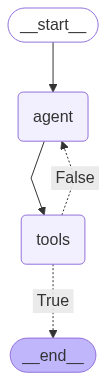

In [15]:
from IPython.display import Image, display

display(Image(compiled.get_graph().draw_mermaid_png()))

In [ ]:
result = compiled.invoke({})
print(result)


: USER: I want to dive tomorrow morning 8am

🤖 AI: Great, we have the following details:

- **Title:** Dive
- **Date:** Tomorrow
- **Time:** 8am

Could you please let me know how long the dive will last?


ValueError: No message found in input